<a href="https://colab.research.google.com/github/tbonza/ds5220/blob/master/full_connected_softmax_dropout.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary

Constructing a fully connected neural network with a softmax activation function in the output layer. This is meant as a comparison for "Quick, Draw!" models using CNN, etc.

# Dependencies

Try to keep all the dependencies in one place.

In [1]:
!pip install cloudpickle
!pip install dask

In [2]:
import ast
import base64
import io
import math
import os
import zipfile

from dask import bag
from google.colab import drive
import h5py
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from PIL import Image, ImageDraw
import scipy as sp
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from sklearn.metrics import accuracy_score

import tensorflow as tf
from tensorflow.python.framework import ops

Using TensorFlow backend.


# Data 

Loading the data from the [QuickDraw](https://www.kaggle.com/c/quickdraw-doodle-recognition) contest. We also need to convert it, resize it, then put it in a matrix.

In [3]:
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
X_TRAIN = "gdrive/My Drive/gcolab/X_train.hdf5"
Y_TRAIN = "gdrive/My Drive/gcolab/y_train.hdf5"
PNG_FOLDER = "gdrive/My Drive/gcolab/png/"
NPY_FOLDER = "gdrive/My Drive/gcolab/npy/"

In [0]:
def load_data(category, label, sample_size=None):
    x = np.load(NPY_FOLDER + category + ".npy")
    y = np.array([label] * x.shape[0])
      
    ## Trimming the category to sample size
    if(sample_size != None):
        x = x[:sample_size,:]
        y = y[:sample_size]
    print("Category: {}, Label: {}, X-Shape: {} & Y-Shape: {}".\
          format(category, label, x.shape, y.shape))
    return (x,y)

In [0]:
def plot_samples(input_array, rows=1, cols=5, title=''):
    fig, ax = plt.subplots(figsize=(cols,rows))
    ax.axis('off')
    plt.title(title)

    for i in list(range(0, min(len(input_array),(rows*cols)) )):      
        a = fig.add_subplot(rows,cols,i+1)
        imgplot = plt.imshow(input_array[i,:784].reshape((28,28)), cmap='gray_r', interpolation='nearest')
        plt.xticks([])
        plt.yticks([])

In [0]:
def resahape_data(x, y):
    x = x.reshape(x.shape[0], 28, 28, 1).astype('float32')
    # one hot encode outputs
    y = np_utils.to_categorical(y)
    print("After reshape, x: {}, y:{}".format(x.shape, y.shape))
    return(x, y)

In [0]:
# train/test split (divide by 255 to obtain normalized values between 0 and 1)
# Use a 50:50 split, training the models on 10'000 samples and thus have plenty of samples to spare for testing.
def get_train_test(x, y):
    x_train, x_test, y_train, y_test = train_test_split(x/255., y, test_size=0.2, random_state=0)
    return(x_train, x_test, y_train, y_test)

In [9]:
categories = ["fish", "fork", "hotdog", "flamingo", "airplane", "alarmclock", 
              "baseballbat", "bicycle", "dolphin", "elephant"]
#categories = ["airplane", "hotdog"]
x = None
y = None
for i in range(len(categories)):
    if(i == 0):
        x_temp, y_temp = load_data(categories[i], i, 20000)
        #plot_samples(x_temp, rows=1, cols=5, title=categories[i])
        x = x_temp
        y = y_temp
    else:
        x_temp, y_temp = load_data(categories[i], i, 20000)
        #plot_samples(x_temp, rows=1, cols=5, title=categories[i])
        x = np.concatenate((x, x_temp), axis=0).astype('float32')
        y = np.concatenate((y, y_temp), axis=0).astype('float32')
print("Shape, x: {}, y:{}".format(x.shape, y.shape))

Category: fish, Label: 0, X-Shape: (20000, 784) & Y-Shape: (20000,)
Category: fork, Label: 1, X-Shape: (20000, 784) & Y-Shape: (20000,)
Category: hotdog, Label: 2, X-Shape: (20000, 784) & Y-Shape: (20000,)
Category: flamingo, Label: 3, X-Shape: (20000, 784) & Y-Shape: (20000,)
Category: airplane, Label: 4, X-Shape: (20000, 784) & Y-Shape: (20000,)
Category: alarmclock, Label: 5, X-Shape: (20000, 784) & Y-Shape: (20000,)
Category: baseballbat, Label: 6, X-Shape: (20000, 784) & Y-Shape: (20000,)
Category: bicycle, Label: 7, X-Shape: (20000, 784) & Y-Shape: (20000,)
Category: dolphin, Label: 8, X-Shape: (20000, 784) & Y-Shape: (20000,)
Category: elephant, Label: 9, X-Shape: (20000, 784) & Y-Shape: (20000,)
Shape, x: (200000, 784), y:(200000,)


# Constructing the Fully Connected Neural Network with Softmax

Use Tensorflow to train a fully connected neural network. 

In [0]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):
    """
    Creates a list of random minibatches from (X, Y)
    
    Arguments:
    X -- input data, of shape (input size, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    mini_batch_size - size of the mini-batches, integer
    seed -- this is only for the purpose of grading, so that you're "random minibatches are the same as ours.
    
    Returns:
    mini_batches -- list of synchronous (mini_batch_X, mini_batch_Y)
    """
    
    m = X.shape[1]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[:, permutation]
    shuffled_Y = Y[:, permutation].reshape((Y.shape[0],m))

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = math.floor(m/mini_batch_size) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch_Y = shuffled_Y[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch_Y = shuffled_Y[:, num_complete_minibatches * mini_batch_size : m]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [0]:
def convert_to_one_hot(Y, C):
    Y = np.eye(C)[Y.reshape(-1)].T
    return Y

In [0]:
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [10000, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

In [0]:
def create_placeholders(n_x, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_x -- scalar, size of an image vector (num_px * num_px = 64 * 64 * 3 = 12288)
    n_y -- scalar, number of classes (from 0 to 5, so -> 6)
    
    Returns:
    X -- placeholder for the data input, of shape [n_x, None] and dtype "float"
    Y -- placeholder for the input labels, of shape [n_y, None] and dtype "float"
    
    Tips:
    - You will use None because it let's us be flexible on the number of examples you will for the placeholders.
      In fact, the number of examples during test/train is different.
    """

    ### START CODE HERE ### (approx. 2 lines)
    X = tf.placeholder(tf.float32, name = 'X', shape=(n_x,None))
    Y = tf.placeholder(tf.float32, name = 'Y', shape=(n_y,None))
    ### END CODE HERE ###
    
    return X, Y

In [0]:
def initialize_parameters():
    """
    Initializes parameters to build a neural network with tensorflow. The shapes are:
                        W1 : [25, 12288]
                        b1 : [25, 1]
                        W2 : [12, 25]
                        b2 : [12, 1]
                        W3 : [6, 12]
                        b3 : [6, 1]
    
    Returns:
    parameters -- a dictionary of tensors containing W1, b1, W2, b2, W3, b3
    """
    
    tf.set_random_seed(1)                   # so that your "random" numbers match ours
        
    ### START CODE HERE ### (approx. 6 lines of code)
    W1 = tf.get_variable("W1", [25,784], initializer= tf.contrib.layers.xavier_initializer(seed=1))
    b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
    W2 = tf.get_variable("W2", [12,25], initializer= tf.contrib.layers.xavier_initializer(seed=1))
    b2 = tf.get_variable("b2", [12, 1], initializer= tf.zeros_initializer())
    W3 = tf.get_variable("W3", [10,12], initializer= tf.contrib.layers.xavier_initializer(seed=1))
    b3 = tf.get_variable("b3", [10, 1], initializer=tf.zeros_initializer())
    ### END CODE HERE ###

    parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
    return parameters

In [0]:
def forward_propagation(X, parameters):
    """
    Implements the forward propagation for the model: LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
    
    Arguments:
    X -- input dataset placeholder, of shape (input size, number of examples)
    parameters -- python dictionary containing your parameters "W1", "b1", "W2", "b2", "W3", "b3"
                  the shapes are given in initialize_parameters

    Returns:
    Z3 -- the output of the last LINEAR unit
    """
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3']
    
    ### START CODE HERE ### (approx. 5 lines)              # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1,X), b1)                        # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2,A1), b2)                      # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3,A2), b3)                      # Z3 = np.dot(W3,Z2) + b3
    ### END CODE HERE ###
    
    return Z3

In [0]:
def compute_cost(Z3, Y, lambd):
    """
    Computes the cost
    
    Arguments:
    Z3 -- output of forward propagation (output of the last LINEAR unit), of shape (6, number of examples)
    Y -- "true" labels vector placeholder, same shape as Z3
    
    Returns:
    cost - Tensor of the cost function
    """
    
    # to fit the tensorflow requirement for tf.nn.softmax_cross_entropy_with_logits(...,...)
    logits = tf.transpose(Z3)
    labels = tf.transpose(Y)
    
    # Include dropout
    logits = tf.nn.dropout(logits, lambd)
    
    # compute cost
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(logits=logits, labels=labels))
    
    return cost

In [0]:
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          lambd = 0.001, num_epochs = 1500, minibatch_size = 100, print_cost = True):
    """
    Implements a three-layer tensorflow neural network: LINEAR->RELU->LINEAR->RELU->LINEAR->SOFTMAX.
    
    Arguments:
    X_train -- training set, of shape (input size = 12288, number of training examples = 1080)
    Y_train -- test set, of shape (output size = 6, number of training examples = 1080)
    X_test -- training set, of shape (input size = 12288, number of training examples = 120)
    Y_test -- test set, of shape (output size = 6, number of test examples = 120)
    learning_rate -- learning rate of the optimization
    num_epochs -- number of epochs of the optimization loop
    minibatch_size -- size of a minibatch
    print_cost -- True to print the cost every 100 epochs
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    seed = 3                                          # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of shape (n_x, n_y)
    ### START CODE HERE ### (1 line)
    X, Y = create_placeholders(n_x, n_y)
    ### END CODE HERE ###

    # Initialize parameters
    ### START CODE HERE ### (1 line)
    parameters = initialize_parameters()
    ### END CODE HERE ###
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    ### START CODE HERE ### (1 line)
    Z3 = forward_propagation(X, parameters)
    ### END CODE HERE ###
    
    # Cost function: Add cost function to tensorflow graph
    ### START CODE HERE ### (1 line)
    cost = compute_cost(Z3, Y, lambd)
    ### END CODE HERE ###
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
    ### START CODE HERE ### (1 line)
    optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(cost)
    ### END CODE HERE ###
    
    # Initialize all the variables
    init = tf.global_variables_initializer()

    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            epoch_cost = 0.                       # Defines a cost related to an epoch
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                
                # IMPORTANT: The line that runs the graph on a minibatch.
                # Run the session to execute the "optimizer" and the "cost", the feedict should contain a minibatch for (X,Y).
                ### START CODE HERE ### (1 line)
                _ , minibatch_cost = sess.run([optimizer, cost], 
                                              feed_dict={X: minibatch_X, Y: minibatch_Y})
                ### END CODE HERE ###
                
                epoch_cost += minibatch_cost / num_minibatches

            # Print the cost every epoch
            if print_cost == True and epoch % 100 == 0:
                print ("Cost after epoch %i: %f" % (epoch, epoch_cost))
            if print_cost == True and epoch % 5 == 0:
                costs.append(epoch_cost)
                
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # lets save the parameters in a variable
        parameters = sess.run(parameters)
        print ("Parameters have been trained!")

        # Calculate the correct predictions
        correct_prediction = tf.equal(tf.argmax(Z3), tf.argmax(Y))

        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))

        print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
        print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
        return parameters

# Running the Model

We want to run the fully connected neural network.

In [0]:
#x, y = resahape_data(x, y)
X_train, X_test, y_train, y_test = get_train_test(x, y)

In [19]:
X_train = X_train.T
X_test = X_test.T

X_train.shape

(784, 100000)

In [0]:

depth = len(categories)
sess = tf.Session()
y_train = sess.run(tf.one_hot(y_train, depth))
y_test = sess.run(tf.one_hot(y_test, depth))

In [21]:
y_train = y_train.T
y_test = y_test.T

y_train.shape

(10, 100000)

Cost after epoch 0: 1.375224
Cost after epoch 100: 0.868620
Cost after epoch 200: 0.838703
Cost after epoch 300: 0.824353
Cost after epoch 400: 0.818657
Cost after epoch 500: 0.815188
Cost after epoch 600: 0.808385
Cost after epoch 700: 0.801546
Cost after epoch 800: 0.799282
Cost after epoch 900: 0.794118
Cost after epoch 1000: 0.794685
Cost after epoch 1100: 0.790670
Cost after epoch 1200: 0.788910
Cost after epoch 1300: 0.786905
Cost after epoch 1400: 0.786805
Cost after epoch 1500: 0.786403


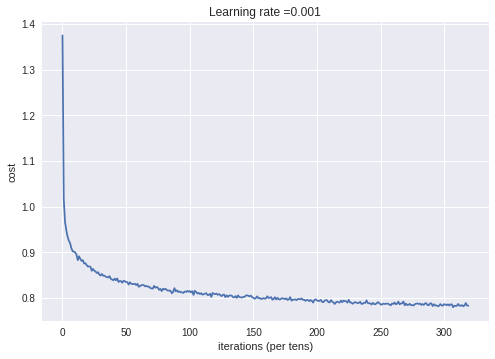

Parameters have been trained!
Train Accuracy: 0.87288
Test Accuracy: 0.78976


In [22]:
parameters = model(X_train, y_train, X_test, y_test, learning_rate=0.001,  
                   lambd=0.7, num_epochs =1600, minibatch_size=64)